In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import os
import re

from IPython.display import clear_output

%matplotlib inline

------
<a id="indice"></a>

# Índice

1. **[Coleta](#coleta)**
    * [Twitter Archive](#coleta:twitter-archive)
    * [Image Prediction](#coleta:image-prediction)
    * [Twitter API](#coleta:twitter-api)
    
    
2. **[Avaliação](#avaliacao)**
    * [Twitter Archive](#avaliacao:twitter-archive)
    * [Image Prediction](#avaliacao:image-prediction)
    * [Twitter API](#avaliacao:twitter-api)
    * [Notas da avaliação](#avaliacao:anotacoes)
    
    
3. **[Limpeza](#limpeza)**
    * [Definição](#limpeza:definicao)
    * [Twitter Archive](#limpeza:twitter-archive)
    * [Image Prediction](#limpeza:image-prediction)
    * [Twitter API](#limpeza:twitter-api)
    
    
4. **[Master dataframe](#master-dataframe)**


5. **[Armazenamento](#armazenamento)**


6. **[Insights](#insights)**

------
<a id="coleta"></a>

# Coleta

<a id="coleta:twitter-archive"></a>

## Coleta: Twitter archive

In [2]:
df_twitter_arc = pd.read_csv('data/twitter-archive-enhanced.csv')
df_twitter_arc.sample(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1036,744971049620602880,NaN,NaN,2016-06-20 19:11:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Indie and Jupiter. They're having...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/744971049...,12,10,Indie,None,None,None,None
1699,680970795137544192,NaN,NaN,2015-12-27 04:37:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I thought I made this very clear. We only rate...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680970795...,9,10,None,None,None,None,None


<a id="coleta:image-prediction"></a>

## Coleta: Image prediction

In [3]:
df_prediction = None

r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

if r.status_code is 200:
    df_prediction = pd.read_csv(pd.compat.StringIO(r.text), sep='\t')    
else:    
    print('ERROR: Image prediction request returned {status_code} status code.'.format(status_code = r.status_code))

In [4]:
df_prediction.sample(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
995,708149363256774660,https://pbs.twimg.com/media/CdPaEkHW8AA-Wom.jpg,1,Cardigan,0.350993,True,basset,0.164555,True,toy_terrier,0.080484,True
1569,794355576146903043,https://pbs.twimg.com/media/CvJCabcWgAIoUxW.jpg,1,cocker_spaniel,0.500509,True,golden_retriever,0.272734,True,jigsaw_puzzle,0.041476,False


<a id="coleta:twitter-api"></a>

## Coleta: Twitter API

In [5]:
# Carregar configuração do Twitter App
with open('twitter_config.json', 'r', encoding='utf-8') as file:
    app_config = json.load(file)

In [6]:
# Atribuição da configurações a variaveis locais
api_key = app_config['api_key']
api_secret = app_config['api_secret']
access_token = app_config['access_token']
access_secret = app_config['access_secret']

In [7]:
# Autentificação ao Twitter App
auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

Buscar dados do histórico de Tweets na API

In [8]:
json_path = 'data/tweet_json.txt'
error_log = 'data/tweet_error.log'

# Salvar Tweets localmente
if(not os.path.isfile(json_path)):
    print('Aguarde. Dado o volume de requisições, a coleta de tweets pode demorar alguns minutos.')
    tweet_count = 0
    for tweet_id in df_twitter_arc.tweet_id:
        print('{percent}%'.format(percent=int((++tweet_count/df_twitter_arc.tweet_id.size)*100)))
        try:
            status = api.get_status(tweet_id)
            with open(json_path, 'a', newline='\n') as file:
                file.write(f'{json.dumps(status._json)}\n')

        except Exception as err:
            with open(error_log, 'a', newline='\n') as log:
                log.write(f'{str(tweet_id)}: {str(err.args[0])}\n')
            print(f'{str(tweet_id)}: {str(err.args[0])}')
        
        clear_output(wait=True)
else:
    print('Dados já salvos em disco, não serão executadas novas requisições à API do Twitter.')
        

Dados já salvos em disco, não serão executadas novas requisições à API do Twitter.


In [9]:
# Criar uma lista de Dictionaries com os Tweets carregados
tweets = []

with open(json_path, 'r') as file:
    for line in file:
        try:
            tweet = json.loads(line)
            
            if(tweet.get('entities', False)):
                if(tweet['entities'].get('media', False) and tweet['entities']['media'][0].get('media_url', False)):
                    tweets.append({
                        'id': int(tweet['id']),
                        'created_at': tweet['created_at'],
                        'in_reply_to_status_id': str(tweet['in_reply_to_status_id']),
                        'in_reply_to_user_id': str(tweet['in_reply_to_user_id']),
                        'is_quote_status': tweet['is_quote_status'],
                        'retweet_count': int(tweet['retweet_count']),
                        'favorite_count': int(tweet['favorite_count']),
                        'media_url': tweet['entities']['media'][0]['media_url'],
                        'retweeted': tweet['retweeted'],
                        'favorited': tweet['favorited']
                    })
            
            
        except Exception as e:
            print(e) 
            
        

In [10]:
# Criar dataframe de Tweets consultados na API
columns = tweets[0].keys()
df_tweets_api = pd.DataFrame(tweets, columns = columns)

------
<a id="avaliacao"></a>

# Avaliação

<a id="avaliacao:twitter-archive"></a>

## Avaliação: Twitter data archive

In [11]:
 df_twitter_arc.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
1052,742528092657332225,NaN,NaN,2016-06-14 01:24:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Maxaroni. He's pumped as hell for the ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/742528092...,10,10,Maxaroni,None,None,None,None
292,838083903487373313,NaN,NaN,2017-03-04 17:49:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Daisy. She's puppears to be rare as al...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/838083903...,13,10,Daisy,None,None,None,None
1390,700151421916807169,NaN,NaN,2016-02-18 02:54:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",If a pupper gave that to me I'd probably start...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/700151421...,11,10,None,None,None,pupper,None
1765,678410210315247616,NaN,NaN,2015-12-20 03:02:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Jerome. He can shoot french fries...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/678410210...,10,10,Jerome,None,None,None,None


In [12]:
df_twitter_arc.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [13]:
df_twitter_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

<a id="twitter-arc:info"></a>
* Dados incompletos, contém apenas 2356 registros dos 5000 anunciados
* `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id` e `retweeted_status_user_id` em `float`
* `timestamp` e `retweeted_status_timestamp` em `string`

In [14]:
# Verificar se há IDs duplicados
df_twitter_arc[df_twitter_arc.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


<a id="twitter-arc:source"></a>

In [15]:
# Visualizar exemplos de dados da coluna `source`
df_twitter_arc.loc[:, 'source'].sample(10)

322     <a href="http://twitter.com/download/iphone" r...
614     <a href="http://twitter.com/download/iphone" r...
1418    <a href="http://twitter.com/download/iphone" r...
32      <a href="http://twitter.com/download/iphone" r...
1886    <a href="http://twitter.com/download/iphone" r...
387     <a href="http://twitter.com/download/iphone" r...
2239    <a href="http://twitter.com/download/iphone" r...
932     <a href="http://twitter.com/download/iphone" r...
2222    <a href="http://twitter.com/download/iphone" r...
1239    <a href="http://twitter.com/download/iphone" r...
Name: source, dtype: object

Variável `source` é uma URL para a Aplicação utilizada no tweet, sem valor para a unidade de observação

<a id="twitter-arc:name"></a>

In [16]:
# Visualizar exemplos da coluna `name`
df_twitter_arc.name.sample(10)

693         Rory
35          None
829         None
1737           a
1028         Gus
688        Frank
2224        None
1204        None
1515        None
422     Hercules
Name: name, dtype: object

In [17]:
df_twitter_arc[df_twitter_arc.name == 'None'].name.count()

745

* Nomes (`name`) preenchidos com valor literal igual a `'None'`, supostamente um valor não preenchido, vazio

<a id="twitter-arc:category"></id>

In [18]:
# Visualizar exemplo de dados das colunas 'doggo' a 'puppo'
df_twitter_arc.loc[:,'doggo':].sample(10)

,doggo,floofer,pupper,puppo
573,None,None,None,None
1995,None,None,pupper,None
1573,None,None,None,None
1677,None,None,None,None
367,None,None,None,None
1130,None,None,None,None
519,None,None,None,None
94,None,None,None,puppo
731,doggo,None,None,None
420,None,None,None,None


* Valores não preenchidos como 'None' literal

Uma variável em várias colunas

In [19]:
# Verificar padrão no preenchimento das classificações
df_twitter_arc.loc[:,'doggo':].nunique()

doggo      2
floofer    2
pupper     2
puppo      2
dtype: int64

In [20]:
df_twitter_arc.loc[:, 'doggo':'puppo'].isna().sum()

doggo      0
floofer    0
pupper     0
puppo      0
dtype: int64

<a id="twitter-arc:expanded_urls"></a>

Exemplos da coluna `expanded_urls`

In [21]:
df_twitter_arc.loc[:, 'expanded_urls'].sample(20)

1734    https://twitter.com/dog_rates/status/679736210...
1796    https://twitter.com/dog_rates/status/677301033...
856     https://twitter.com/dog_rates/status/764259802...
434     https://www.loveyourmelon.com/pages/ourstory,h...
1834                        https://vine.co/v/iZXg7VpeDAv
1147    https://twitter.com/dog_rates/status/726935089...
359     https://twitter.com/dog_rates/status/826958653...
1055    https://twitter.com/dog_rates/status/742385895...
1248    https://twitter.com/dog_rates/status/711363825...
799     https://twitter.com/dog_rates/status/772826264...
846     https://twitter.com/dog_rates/status/766313316...
1001    https://twitter.com/dog_rates/status/747933425...
1736    https://twitter.com/dog_rates/status/679722016...
289     https://twitter.com/dog_rates/status/820749716...
1320    https://twitter.com/dog_rates/status/706346369...
1365    https://twitter.com/dog_rates/status/702684942...
307     https://twitter.com/dog_rates/status/786963064...
2320    https:

In [22]:
df_twitter_arc.loc[:, 'expanded_urls'].isna().value_counts()

False    2297
True       59
Name: expanded_urls, dtype: int64

* Registros de `expanded_urls` com URLs para os twittes originais. Não apresenta valor a unidade em observacão

------
<a id="avaliacao:image-prediction"></a>

## Avaliação: Image prediction

In [23]:
df_prediction.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


<a id="image-prediction:info"></info>

In [24]:
df_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [25]:
df_prediction.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
832,693647888581312512,https://pbs.twimg.com/media/CaBVE80WAAA8sGk.jpg,1,washbasin,0.272451,False,doormat,0.165871,False,bathtub,0.066368,False
1947,862722525377298433,https://pbs.twimg.com/media/C_kBjuUUIAArs2-.jpg,1,basset,0.393330,True,beagle,0.242034,True,boxer,0.077692,True
698,684567543613382656,https://pbs.twimg.com/media/CYASi6FWQAEQMW2.jpg,1,minibus,0.401942,False,llama,0.229145,False,seat_belt,0.209393,False
160,668902994700836864,https://pbs.twimg.com/media/CUhruUgUAAAa8FQ.jpg,1,Brittany_spaniel,0.828425,True,Ibizan_hound,0.043082,True,Blenheim_spaniel,0.028004,True
1547,792773781206999040,https://pbs.twimg.com/media/CwB_i-zXEAEiP29.jpg,1,Yorkshire_terrier,0.912804,True,silky_terrier,0.067823,True,Australian_terrier,0.004451,True
614,680161097740095489,https://pbs.twimg.com/media/CXBq6RPWkAAaNuU.jpg,1,bluetick,0.268681,True,miniature_pinscher,0.125652,True,English_setter,0.089373,True
1256,748568946752774144,https://pbs.twimg.com/ext_tw_video_thumb/74856...,1,Tibetan_terrier,0.328161,True,toy_poodle,0.304836,True,miniature_poodle,0.070878,True
1896,850145622816686080,https://pbs.twimg.com/media/C8xS655XkAAv9vo.jpg,2,tennis_ball,0.714798,False,kelpie,0.105390,True,malinois,0.058553,True
787,690374419777196032,https://pbs.twimg.com/media/CZSz3vWXEAACElU.jpg,1,kuvasz,0.286345,True,Labrador_retriever,0.107144,True,ice_bear,0.085086,False
14,666094000022159362,https://pbs.twimg.com/media/CT5w9gUW4AAsBNN.jpg,1,bloodhound,0.195217,True,German_shepherd,0.078260,True,malinois,0.075628,True


<a id="image-prediction:p-values"></a>

Valores não padronizados para as variáveis `p1`, `p2` e `p3`

In [26]:
# Visualização de exemplos de valores nas colunas `p1`, `p2` e `p3`
df_prediction.loc[:, ['p1', 'p2', 'p3']].sample(5)

,p1,p2,p3
419,Eskimo_dog,Norwegian_elkhound,malamute
1497,Chihuahua,miniature_pinscher,toy_terrier
1574,golden_retriever,Chesapeake_Bay_retriever,soft-coated_wheaten_terrier
690,Chihuahua,toy_terrier,Boston_bull
359,golden_retriever,Labrador_retriever,clumber


<a id="image-prediction:duplicated-urls"></a>

Verificar a duplicidade de Tweet ID (`tweet_id`) e Imagens (`jpg_url`)

In [27]:
# Verificar a duplicidade de IDs
df_prediction.tweet_id.nunique()

2075

Verificar a duplicidade na coluna `jpg_url`

In [28]:
df_prediction.jpg_url.duplicated().value_counts()

False    2009
True       66
Name: jpg_url, dtype: int64

Há 66 imagens duplicadas

In [29]:
# Validar indicadores de confiabiliade da predição
df_prediction.loc[:, ['p1_conf', 'p2_conf', 'p3_conf']].max()

p1_conf    1.000000
p2_conf    0.488014
p3_conf    0.273419
dtype: float64

------
<a id="avaliacao:twitter-api"></a>

## Avaliação: Twitter API Requests

In [30]:
df_tweets_api.describe()

,id,retweet_count,favorite_count
count,1.820000e+03,1820.000000,1820.000000
mean,7.237270e+17,2512.144505,6820.872527
std,5.777841e+16,4891.076169,11900.984651
min,6.660209e+17,11.000000,0.000000
25%,6.747671e+17,536.000000,1363.500000
50%,7.008223e+17,1118.000000,3153.000000
75%,7.617466e+17,2526.250000,7463.250000
max,8.924206e+17,82905.000000,163034.000000


<a id="tweets-api:info"></a>

In [31]:
df_tweets_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820 entries, 0 to 1819
Data columns (total 10 columns):
id                       1820 non-null int64
created_at               1820 non-null object
in_reply_to_status_id    1820 non-null object
in_reply_to_user_id      1820 non-null object
is_quote_status          1820 non-null bool
retweet_count            1820 non-null int64
favorite_count           1820 non-null int64
media_url                1820 non-null object
retweeted                1820 non-null bool
favorited                1820 non-null bool
dtypes: bool(3), int64(3), object(4)
memory usage: 104.9+ KB


Os nomes das colunas `id` e `media_url` estão fora do padrão dos demais dataframes, respectivamente `tweet_id` e `jpg_url` 

In [32]:
df_tweets_api.sample(5)

,id,created_at,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,retweet_count,favorite_count,media_url,retweeted,favorited
1677,668614819948453888,Mon Nov 23 02:19:29 +0000 2015,None,None,False,318,616,http://pbs.twimg.com/media/CUdloW8WEAAxB_Y.jpg,False,False
1069,688064179421470721,Fri Jan 15 18:24:18 +0000 2016,None,None,False,381,1804,http://pbs.twimg.com/media/CYx-tGaUoAAEXV8.jpg,False,False
130,823269594223824897,Sun Jan 22 20:42:21 +0000 2017,None,None,False,10609,0,http://pbs.twimg.com/media/C2kzTGxWEAEOpPL.jpg,False,False
1612,669942763794931712,Thu Nov 26 18:16:16 +0000 2015,None,None,False,168,507,http://pbs.twimg.com/media/CUwdYL5UsAAP0XX.jpg,False,False
601,743980027717509120,Sat Jun 18 01:33:55 +0000 2016,None,None,False,1152,4327,http://pbs.twimg.com/media/ClMl4VLUYAA5qBb.jpg,False,False


* `created_at` como `string`
* `in_reply_to_status_id` e `in_reply_to_userid` como `string`

<a id="tweets-api:duplicated"></a>
Verificar a duplicidade de valores

In [33]:
# Verificar se há IDs duplicados
df_tweets_api.id.duplicated().value_counts()

False    1820
Name: id, dtype: int64

In [34]:
# Verificar se há imagens duplicadas
df_tweets_api.media_url.duplicated().value_counts()

False    1759
True       61
Name: media_url, dtype: int64

Há tweets referenciando a mesma imagem

------

<a id="avaliacao:anotacoes"></a>

## Notas da avaliação
### Qualidade

#### `df_twitter_arc` - Twitter archive
1. [Base incompleta, contém apenas **2356** registros dos **5000** anunciados](#twitter-arc:info)
* [Coluna `source` sem valor à unidade de obsevação](#twitter-arc:source)
* [Nomes (`name`) preenchidos com valor literal igual a `'None'`, vazio](#twitter-arc:name)
* [Coluna `expanded_urls` sem valor à unidade de observação](#twitter-arc:expanded_urls)
* [Categorias \[`doggo`, `floofer`, `pupper`, `puppo`\] com literal `'None'`](#twitter-arc:category)


#### `df_prediction` - Image prediction
1. [Previsões \[`p1`, `p2`, `p3`\] com nomes não padronizados](#image-prediction:p-values)
* [Duplicidade na coluna `jgp_url`](#image-prediction:duplicated-urls)


#### `df_tweets_api` - Twitter API
1. [Diferentes Tweets referenciando a mesma imagem, duplicidade](#tweets-api:duplicated)


### Organização

#### `df_twitter_arc` - Twitter archive
1. [As colunas `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` estão em `float64`](#twitter-arc:info)
* [As colunas `timestamp` e `retweet_status_timestamp` estão em `string`](#twitter-arc:info)
* [Uma variável em várias colunas, `doggo`, `floofer`, `pupper` e `puppo`](#twitter-arc:category)


#### `df_prediction` - Image prediction
1. [Colunas como variáveis na identificação das predições](#image-prediction:info)


#### `df_tweets_api` - Twitter API
1. [Os nomes das colunas `id` e `media_url` estão fora do padrão dos demais dataframes, respectivamente `tweet_id` e `jpg_url` ](#tweets-api:info)
* [Data de criação (`created_at`) como `string`](#tweets-api:info)
* [As colunas `in_reply_to_status_id` e `in_reply_to_user_id` em `string`](#tweets-api:info)

------

<a id="limpeza"></a>

# Limpeza

<a id="limpeza:definicao"></a>

## Limpeza: Definição 

#### `df_twitter_arc` - Twitter archive
1. [Base incompleta, de **5000**, apenas **2356** estão disponíveis](#limpeza:twitter-arc:completeness)
    * OK - Nada a ser feito
* [Coluna `source` sem valor à unidade de observação](#limpeza:twitter-arc:source)
    * O conteúdo apresenta um link para download do App Twitter, portanto não agrega valor à unidade de observação, a coluna pode ser removida
* [Nomes (`name`) não preenchidos com valor literal igual a `'None'`](#limpeza:twitter-arc:name)
    * Alterar valores como 'None' para `np.nan`
* [Coluna `expanded_urls` sem valor à unidade de observação](#limpeza:twitter-arc:expanded_urls)(#twitter-arc:expanded_urls)
    * Não apresentam valor à unidade de observação, são URLs para os tweets em questão. Remover a coluna `expanded_urls`.
* [Categorias \[doggo, floofer, pupper, puppo\] com literal `'None'`](#limpeza:twitter-arc:category)
    * Aplicar valor `np.nan` para nomes iguais a 'None'   
* [As colunas `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` estão em `float64`](#limpeza:twitter-arc:info)
    * Linhas com valor para as colunas `retweeted_status_id` ou `retweeted_status_user_id` podem ser descartadas por indicarem retweet, o objetivo é analisar somente tweets originais
    * Após a remoção retweets, as colunas `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, podem ser descartadas
    * As colunas `in_reply_to_status_id` e `in_reply_to_user_id` serão retratadas no dataframe `df_tweets_api`
* [As colunas `timestamp` e `retweet_status_timestamp` estão em `string` e deveriam ser do tipo `datetime`](#limpeza:twitter-arc:datetime)
    * Converter valores para `datetime`
* [Uma variável em várias colunas, `doggo`, `floofer`, `pupper` e `puppo`](#limpeza:twitter-arc:category-merge)
    * Cada variável em apenas uma coluna,  `category`


#### `df_prediction` - Image prediction
1. [Previsões \[`p1`, `p2`, `p3`\] com nomes não padronizados](#limpeza:image-prediction:names)
    * Converter os valores para 'lower case' e substituir '_' por espaços
* [Previsões repetidas sobre a mesma imagem](#limpeza:image-prediction:duplicated-urls)
    * Descartar predições sobre imagens repetidas
* [Colunas como variáveis na identificação das predições](#limpeza:image-prediction:info)
    * Transpor as variáveis nas colunas para linhas


#### `df_tweets_api` - Twitter API
1. [Os nomes das colunas `id` e `media_url` estão fora do padrão dos demais dataframes, respectivamente `tweet_id` e `jpg_url` ](#limpeza:tweets-api:columns)
* [Diferentes Tweets referenciando a mesma imagem, duplicidade](#limpeza:tweets-api:duplicated)
* [Data de criação (`created_at`) como `string`](#limpeza:tweets-api:datetime)
    * Converter datas em string para o formato `datetime`
* [Valor do id na coluna `in_reply_to_status_id` e `in_reply_to_user_id` como `string`](#limpeza:tweets-api:info)
    * Converter para Inteiro as colunas `in_reply_to_status_id` e `in_reply_to_user_id` e atribuir np.nan as que estiverem sem valor

<a id="limpeza:twitter-archive"></a>

## Limpeza: Twitter archive

In [35]:
# Criar cópia do dataframe para a limpeza
df_arch_clean = df_twitter_arc.copy()

<a id="limpeza:twitter-arc:completeness"></a>

### 1. [Base incompleta, de 5000, apenas 2356 estão disponíveis](#limpeza:twitter-arc:completeness)
Nada a ser feito

In [36]:
df_arch_clean.shape

(2356, 17)

<a id="limpeza:twitter-arc:source"></a>

### 2. [Coluna `source` sem valor à unidade de observação](#limpeza:twitter-arc:source)
* O conteúdo apresenta um link para download do App Twitter, portanto não agrega valor à unidade de observação, a coluna pode ser removida

In [37]:
# Remoção da coluna `source`
df_arch_clean.drop('source', axis='columns', inplace=True)

#### Teste: Remoção coluna `source`

In [38]:
# Conferir que a coluna `source` foi removida
df_arch_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

<a id="limpeza:twitter-arc:name"></a>

### 3. [Nomes (`name`) não preenchidos com valor literal igual a `'None'`](#limpeza:twitter-arc:name)
    * Alterar valores como 'None' para `np.nan`

In [39]:
# Contagem de nomes iguais a 'None'
df_arch_clean[df_arch_clean.name.str.lower() == 'none'].name.count()

745

In [40]:
# Função para substituição de valores literais 'None' por np.nan
def set_nan_at_none(value):
    if str(value).lower() == 'none':
        return np.nan
    else:
        return value

In [41]:
# Aplicar `np.nan` aos nomes iguais a 'None'
df_arch_clean.name = df_arch_clean.name.apply(set_nan_at_none)

#### Teste: Aplicação de `np.nan` aos nomes como 'None'

In [42]:
df_arch_clean.name.isnull().sum()

745

In [43]:
df_arch_clean[df_arch_clean.name.str.lower() == 'none'].name.count()

0

In [44]:
df_arch_clean.name.sample(10)

1261         Lacy
1917        Kenny
2266    Naphaniel
939           NaN
757         Penny
2342          NaN
1131         Puff
254       Charlie
533         Ollie
258          Hank
Name: name, dtype: object

<a id="limpeza:twitter-arc:expanded_urls"></a>

### 4. [Coluna `expanded_urls` sem valor à unidade de observação](#limpeza:twitter-arc:expanded_urls)
* Não apresentam valor à unidade de observação, são URLs para os tweets em questão. Remover a coluna `expanded_urls`

In [45]:
df_arch_clean.drop('expanded_urls', axis='columns', inplace=True)

#### Teste: Remoção da coluna `expanded_urls`

In [46]:
df_arch_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'rating_numerator', 'rating_denominator',
       'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

<a id="limpeza:twitter-arc:category"></a>

### 5. [Categorias \[`doggo`, `floofer`, `pupper`, `puppo`\] com literal `'None'`](#limpeza:twitter-arc:category)
* Aplicar valor `np.nan` para nomes iguais a 'None'   

In [47]:
# Trocar valores 'None' para np.nan nas colunas `doggo`, `floofer`, `pupper`, `puppo`
df_arch_clean.doggo = df_arch_clean.doggo.apply(set_nan_at_none)
df_arch_clean.doggo.isna().value_counts()

True     2259
False      97
Name: doggo, dtype: int64

In [48]:
df_arch_clean.floofer = df_arch_clean.floofer.apply(set_nan_at_none)
df_arch_clean.floofer.isna().value_counts()

True     2346
False      10
Name: floofer, dtype: int64

In [49]:
df_arch_clean.pupper = df_arch_clean.pupper.apply(set_nan_at_none)
df_arch_clean.pupper.isna().value_counts()

True     2099
False     257
Name: pupper, dtype: int64

In [50]:
df_arch_clean.puppo = df_arch_clean.puppo.apply(set_nan_at_none)
df_arch_clean.puppo.isna().value_counts()

True     2326
False      30
Name: puppo, dtype: int64

In [51]:
# Soma de valores preenchidos nas classificações
sum_categories = 0
sum_categories += df_arch_clean.doggo.notna().sum()
sum_categories += df_arch_clean.floofer.notna().sum()
sum_categories += df_arch_clean.pupper.notna().sum()
sum_categories += df_arch_clean.puppo.notna().sum()

sum_categories

394

Apenas 394 dos 2346 registros foram classificados

<a id="limpeza:twitter-arc:info"></a>

### 6. [As colunas `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` estão em `float64`](#limpeza:twitter-arc:info)
* Linhas com algum valor para as colunas `retweeted_status_id` ou `retweeted_status_user_id` podem ser descartadas por indicarem retweet, e o objetivo é analisar somente tweets originais
* Após a remoção retweets, as colunas `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, podem ser descartadas
* As colunas `in_reply_to_status_id` e `in_reply_to_user_id` serão retratadas no dataframe `df_tweets_api`

#### Identificação dos tweets originais
df_arch_clean.loc[:,'retweeted_status_id'].isna().value_counts()

In [52]:
df_arch_clean.retweeted_status_id.size

2356

In [53]:
df_arch_clean.loc[:,'retweeted_status_id'].isna().value_counts()

True     2175
False     181
Name: retweeted_status_id, dtype: int64

Dos 2356 registros, 181 são retweets

In [54]:
# Remoção dos retweets
df_arch_clean.drop(df_arch_clean[df_arch_clean.retweeted_status_id.notna()].index, axis=0, inplace=True)

#### Teste: Remoção de Retweets

In [55]:
# Consultar a existência de colunas com retweet_status_preenchido
df_arch_clean.loc[:,'retweeted_status_id'].isna().value_counts()

True    2175
Name: retweeted_status_id, dtype: int64

Remoção das colunas referentes a retweets

In [56]:
df_arch_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis='columns', inplace=True)

#### Teste: Verificação da remoção das colunas referentes a retweets

In [57]:
df_arch_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'text', 'rating_numerator', 'rating_denominator', 'name', 'doggo',
       'floofer', 'pupper', 'puppo'],
      dtype='object')

<a id="limpeza:twitter-arc:datetime"></a>

### 7. [As colunas `timestamp` e `retweet_status_timestamp` estão em `string` e deveriam ser do tipo `datetime`](#limpeza:twitter-arc:datetime)
* Converter valores para `datetime`

Haja vista que a coluna `retweet_status_timestamp` foi removida no passo anterior, não será necessária a sua conversão

In [58]:
df_arch_clean.loc[:, ['timestamp']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 1 columns):
timestamp    2175 non-null object
dtypes: object(1)
memory usage: 34.0+ KB


In [59]:
df_arch_clean.timestamp = pd.to_datetime(df_arch_clean.timestamp)

#### Teste: Veriificação da conversão de `string` para `datetime`

In [60]:
df_arch_clean.loc[:, ['timestamp']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 1 columns):
timestamp    2175 non-null datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1)
memory usage: 34.0 KB


<a id="limpeza:twitter-arc:category-merge"></a>

### 8. [Uma variável em várias colunas, `doggo`, `floofer`, `pupper` e `puppo`](#limpeza:twitter-arc:category-merge)
* Cada variável em apenas uma coluna, reduzi-las a coluna `category`

In [61]:
df_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null datetime64[ns, UTC]
text                     2175 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     1495 non-null object
doggo                    87 non-null object
floofer                  10 non-null object
pupper                   234 non-null object
puppo                    25 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), int64(3), object(6)
memory usage: 220.9+ KB


In [62]:
df_arch_clean.loc[:, 'doggo':].notna().sum()

doggo       87
floofer     10
pupper     234
puppo       25
dtype: int64

In [63]:
df_arch_clean.loc[:, 'doggo':].notna().sum().sum()

356

De **2175** registros, apenas **356** estão classificados

Criar uma lista das categorias para mesclar as colunas, considerando a coluna a esquerda como prioritaria sobre valores nulos a direita.

In [64]:
category = df_arch_clean.doggo
category = category.combine_first(df_arch_clean.floofer)
category = category.combine_first(df_arch_clean.pupper)
category = category.combine_first(df_arch_clean.puppo)

df_arch_clean['category'] = category

In [65]:
df_arch_clean.category.notna().sum()

344

Após a unificação das colunas de classificação, pode-se ver que resultou em apenas **344** registros, diferente dos **356** iniciais. O que indica que haviam registros com mais de uma classificação.

In [66]:
df_arch_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis='columns', inplace=True)

#### Teste: Verificar a criação da coluna `category` a remoção das colunas `doggo`, `floofer`, `pupper` e `puppo`. 

In [67]:
df_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null datetime64[ns, UTC]
text                     2175 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     1495 non-null object
category                 344 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), int64(3), object(3)
memory usage: 169.9+ KB


------
<a id="limpeza:image-prediction"></a>

## Limpeza: Image prediction 

In [68]:
# Cópia do dataframe para limpeza
df_predict_clean = df_prediction.copy()

<a id="limpeza:image-prediction:names"></a>

### 1. [Previsões \[`p1`, `p2`, `p3`\] com nomes não padronizados](#limpeza:image-prediction:names)
* Converter os valores para 'lower case' e substituir '_' por espaços

In [69]:
clean_prediction_name = lambda value: str(value).lower().replace('_', ' ')

In [70]:
df_predict_clean.loc[:, ['p1', 'p2', 'p3']].sample(5)

,p1,p2,p3
384,Chihuahua,Italian_greyhound,miniature_pinscher
630,Labrador_retriever,Siberian_husky,beagle
1138,stone_wall,prison,bannister
106,jigsaw_puzzle,prayer_rug,doormat
268,basset,Walker_hound,beagle


Aplicar a padronização dos nomes em cada uma das colunas de predição

In [71]:
df_predict_clean.p1 = df_predict_clean.p1.apply(clean_prediction_name)

In [72]:
df_predict_clean.p2 = df_predict_clean.p2.apply(clean_prediction_name)

In [73]:
df_predict_clean.p3 = df_predict_clean.p3.apply(clean_prediction_name)

#### Teste: Verificar padronização dos nomes das predições

In [74]:
df_predict_clean.loc[:, ['p1', 'p2', 'p3']].sample(5)

,p1,p2,p3
855,car mirror,chesapeake bay retriever,vizsla
306,doberman,black-and-tan coonhound,gordon setter
381,miniature pinscher,bloodhound,rottweiler
1773,american staffordshire terrier,staffordshire bullterrier,bull mastiff
599,wallaby,west highland white terrier,ashcan


<a id="limpeza:image-prediction:duplicated-urls"></a>

### 2. [Predições repetidas sobre a mesma imagem](#limpeza:image-prediction:duplicated-urls)
* Descartar predições sobre imagens repetidas

In [75]:
df_predict_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [76]:
df_predict_clean.loc[:, ['jpg_url', 'p1', 'p2', 'p3']].duplicated().value_counts()

False    2009
True       66
dtype: int64

Dos **2075** registros, **66** são sobre a mesma imagem. Entretanto, seguindo o objetivo de trabalhar com apenas Tweets originais, além de descartar duplicidade é interessante também descartar as refêrencias a Retweets. Para isso, será feita uma consulta a seleção de Tweets originais, que foi efetuada no passo [6 da limpeza do Twitter Archive](#limpeza:twitter-arc:info)

In [77]:
df_predict_clean = df_predict_clean.loc[df_predict_clean.tweet_id.isin(df_arch_clean.tweet_id)]

#### Teste: Seleção de Tweets originais

In [78]:
df_predict_clean.tweet_id.isin(df_arch_clean.tweet_id).value_counts()

True    1994
Name: tweet_id, dtype: int64

Apenas dos **2075**, **1994** são de Tweets originais

------

Dos Tweets originai ainda é necessário verificar a existência de duplicidade de predições.

In [79]:
df_predict_clean.loc[:, ['jpg_url']].duplicated().value_counts()

False    1994
dtype: int64

Nenhuma duplicidade foi encontrada após a remoção das referências de Retweets

In [80]:
df_predict_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    1994 non-null int64
jpg_url     1994 non-null object
img_num     1994 non-null int64
p1          1994 non-null object
p1_conf     1994 non-null float64
p1_dog      1994 non-null bool
p2          1994 non-null object
p2_conf     1994 non-null float64
p2_dog      1994 non-null bool
p3          1994 non-null object
p3_conf     1994 non-null float64
p3_dog      1994 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 161.6+ KB


<a id="limpeza:image-prediction:info"></a>

### 3. [Colunas como variáveis na identificação das predições](#limpeza:image-prediction:info)
* 3.1. Transpor as variáveis nas colunas para linhas:
    * 3.1.1. [`[p1, p2, p3]`, para `prediction_try` e seus valores para `prediction_breed`](#limpeza:image-prediction:try)
    * 3.1.2. [`[p1_conf, p2_conf, p3_conf]`, para `confidence`](#limpeza:image-prediction:conf)
    * 3.1.3. [`[p1_dog, p2_dog, p3_dog]`, para `is_a_dog`](#limpeza:image-prediction:dog)
* 3.2. [Unir os dataframes de prediction](#limpeza:image-prediction:merge)

In [81]:
df_predict_clean.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
304,671518598289059840,https://pbs.twimg.com/media/CVG2l9jUYAAwg-w.jpg,1,lakeland terrier,0.428275,True,wire-haired fox terrier,0.111472,True,toy poodle,0.105016,True
468,675109292475830276,https://pbs.twimg.com/media/CV54UQTXAAAGf-j.jpg,1,dalmatian,0.989519,True,english setter,0.005258,True,german short-haired pointer,0.001443,True
1162,734912297295085568,https://pbs.twimg.com/media/CjLuzPvUoAAbU5k.jpg,1,maltese dog,0.847292,True,feather boa,0.059379,False,old english sheepdog,0.052758,True
240,670442337873600512,https://pbs.twimg.com/media/CU3jwAYWwAAhdAv.jpg,1,sussex spaniel,0.403552,True,otterhound,0.256302,True,irish terrier,0.187315,True
215,670055038660800512,https://pbs.twimg.com/media/CUyDgChWUAAmNSI.jpg,1,snail,0.563631,False,slug,0.296649,False,bolete,0.031839,False


<a id="limpeza:image-prediction:try"></a>

#### 3.1.1. [Organização das colunas `[p1, p2, p3]`, para `prediction_try` e seus valores para `prediction_breed` ](#limpeza:image-prediction:try)

In [82]:
# Organizando as variáveis de tentativa de predição e seu palpite
df_predict_try = pd.melt(df_predict_clean,
        id_vars=['tweet_id', 'jpg_url'],
        value_vars=['p1', 'p2', 'p3'],
        var_name=['prediction_try'],
        value_name='prediction_breed'
       )

In [83]:
df_predict_try.sample(5)

,tweet_id,jpg_url,prediction_try,prediction_breed
692,684241637099323392,https://pbs.twimg.com/media/CX7qIcdWcAELJ7N.jpg,p1,pembroke
1517,792050063153438720,https://pbs.twimg.com/media/Cv3tU38WcAASFas.jpg,p1,komondor
5180,740365076218183684,https://pbs.twimg.com/media/CkZOGhJWsAAHvPv.jpg,p3,mushroom
295,671390180817915904,https://pbs.twimg.com/media/CVFBzpXVEAAHIOv.jpg,p1,zebra
5096,724046343203856385,https://pbs.twimg.com/media/CgxUTS_XEAAC0pv.jpg,p3,great dane


Conversão dos valores da tentativa para número inteiro

In [84]:
# Metodo para retirar o índice da tentativa dos nomes das colunas
get_prediction_index = lambda value: int(re.sub(r'[^\d]', '', str(value)))

In [85]:
df_predict_try.prediction_try = df_predict_try.prediction_try.apply(get_prediction_index)

In [86]:
df_predict_try.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5982 entries, 0 to 5981
Data columns (total 4 columns):
tweet_id            5982 non-null int64
jpg_url             5982 non-null object
prediction_try      5982 non-null int64
prediction_breed    5982 non-null object
dtypes: int64(2), object(2)
memory usage: 187.0+ KB


In [87]:
df_predict_try.sample(5)

,tweet_id,jpg_url,prediction_try,prediction_breed
4304,671763349865160704,https://pbs.twimg.com/media/CVKVM3NW4AAdi1e.jpg,3,bib
3771,838921590096166913,https://pbs.twimg.com/media/C6Ryuf7UoAAFX4a.jpg,2,brabancon griffon
466,675109292475830276,https://pbs.twimg.com/media/CV54UQTXAAAGf-j.jpg,1,dalmatian
3922,877736472329191424,https://pbs.twimg.com/media/DC5YqoQW0AArOLH.jpg,2,labrador retriever
1708,827600520311402496,https://pbs.twimg.com/media/C3w6RYbWQAAEQ25.jpg,1,pembroke


<a id="limpeza:image-prediction:conf"></a>

#### 3.1.2. [`[p1_conf, p2_conf, p3_conf]`, para `confidence`](#limpeza:image-prediction:conf)

In [88]:
# Movendo o nível de confiança das predições para uma coluna apenas
df_predict_conf = pd.melt(df_predict_clean,
                         id_vars=['tweet_id', 'jpg_url'],
                         value_vars=['p1_conf', 'p2_conf', 'p3_conf'],
                         var_name=['prediction_try'],
                         value_name='confidence'
                        )

In [89]:
df_predict_conf.sample(5)

,tweet_id,jpg_url,prediction_try,confidence
4941,705239209544720384,https://pbs.twimg.com/media/CcmDUjFW8AAqAjc.jpg,p3_conf,0.063225
1391,769212283578875904,https://pbs.twimg.com/media/CqzKfQgXEAAWIY-.jpg,p1_conf,0.166538
1223,745057283344719872,https://pbs.twimg.com/media/Clb5pLJWMAE-QS1.jpg,p1_conf,0.963985
5948,884925521741709313,https://pbs.twimg.com/media/DEfjEaNXkAAtPlj.jpg,p3_conf,0.127725
515,676440007570247681,https://pbs.twimg.com/media/CWMyl9EWUAAnZJ0.jpg,p1_conf,0.579472


In [90]:
# Atribuir apenas valores inteiros aos indicadores de tentativas
df_predict_conf.prediction_try = df_predict_conf.prediction_try.apply(get_prediction_index)

In [91]:
df_predict_conf.sample(5)

,tweet_id,jpg_url,prediction_try,confidence
2945,705102439679201280,https://pbs.twimg.com/media/CckG63qUsAALbIr.jpg,2,0.279101
1921,875747767867523072,https://pbs.twimg.com/media/DCdH8YpUQAAiEbL.jpg,1,0.799551
1186,739606147276148736,https://pbs.twimg.com/media/CkOb3FXW0AAUL_U.jpg,1,0.933755
69,667188689915760640,https://pbs.twimg.com/media/CUJUk2iWUAAVtOv.jpg,1,0.335830
866,697596423848730625,https://pbs.twimg.com/media/Ca5cPrJXIAImHtD.jpg,1,0.621668


In [92]:
df_predict_conf.shape

(5982, 4)

<a id="limpeza:image-prediction:dog"></a>

#### 3.1.3. [`[p1_dog, p2_dog, p3_dog]`, para `is_a_dog`](#limpeza:image-prediction:dog)

In [93]:
# Movendo o resultado da predição, `p#_dog` para `is_a_dog`
df_predict_dog = pd.melt(df_predict_clean,
                        id_vars=['tweet_id', 'jpg_url'],
                        value_vars=['p1_dog', 'p2_dog', 'p3_dog'],
                        var_name=['prediction_try'],
                        value_name='is_a_dog')

In [94]:
df_predict_dog.sample(5)

,tweet_id,jpg_url,prediction_try,is_a_dog
3656,819227688460238848,https://pbs.twimg.com/media/C157Oq3WQAEOyHm.jpg,p2_dog,True
3039,713411074226274305,https://pbs.twimg.com/media/CeaLlAPUMAIcC7U.jpg,p2_dog,True
2033,666649482315059201,https://pbs.twimg.com/media/CUBqKnLWwAA5OQB.jpg,p2_dog,True
268,670822709593571328,https://pbs.twimg.com/media/CU89schWIAIHQmA.jpg,p1_dog,False
5514,793180763617361921,https://pbs.twimg.com/media/CwHxsdYVMAAqGCJ.jpg,p3_dog,True


In [95]:
# Atribuir apenas valores inteiros aos indicadores de tentativas
df_predict_dog.prediction_try = df_predict_dog.prediction_try.apply(get_prediction_index)

In [96]:
df_predict_dog.sample(5)

,tweet_id,jpg_url,prediction_try,is_a_dog
397,673686845050527744,https://pbs.twimg.com/media/CVlqi_AXIAASlcD.jpg,1,True
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,True
2332,672248013293752320,https://pbs.twimg.com/media/CVROAIfWsAECA5t.jpg,2,True
5349,762464539388485633,https://pbs.twimg.com/media/CpTRc4DUEAAYTq6.jpg,3,False
5084,720415127506415616,https://pbs.twimg.com/media/Cf9tuHUWsAAHSrV.jpg,3,False


In [97]:
df_predict_dog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5982 entries, 0 to 5981
Data columns (total 4 columns):
tweet_id          5982 non-null int64
jpg_url           5982 non-null object
prediction_try    5982 non-null int64
is_a_dog          5982 non-null bool
dtypes: bool(1), int64(2), object(1)
memory usage: 146.1+ KB


<a id="limpeza:image-prediction:merge"></a>

#### 3.2. [Unir os dataframes de prediction](#limpeza:image-prediction:merge)

In [98]:
# Merge
df_predict_clean = pd.merge(df_predict_try, df_predict_conf, how='left', on=['tweet_id', 'jpg_url', 'prediction_try'])

In [99]:
df_predict_clean.shape

(5982, 5)

In [100]:
df_predict_clean.sample(5)

,tweet_id,jpg_url,prediction_try,prediction_breed,confidence
3748,834458053273591808,https://pbs.twimg.com/media/C5SXK89XUAQg7GX.jpg,2,whippet,0.177531
536,676949632774234114,https://pbs.twimg.com/media/CWUCGMtWEAAjXnS.jpg,1,welsh springer spaniel,0.206479
3755,835297930240217089,https://pbs.twimg.com/media/C5eTCOVUsAAWhvc.jpg,2,border terrier,0.336220
5357,765222098633691136,https://pbs.twimg.com/media/Cp6db4-XYAAMmqL.jpg,3,american staffordshire terrier,0.096435
2069,667405339315146752,https://pbs.twimg.com/media/CUMZnmhUEAEbtis.jpg,2,leonberg,0.127998


In [101]:
df_predict_clean = pd.merge(df_predict_clean, df_predict_dog, how='left', on=['tweet_id', 'jpg_url', 'prediction_try'])

In [102]:
df_predict_clean.shape

(5982, 6)

**Teste: Verificar Merge dos dataframes de predição**

In [103]:
df_predict_clean.sample(5)

,tweet_id,jpg_url,prediction_try,prediction_breed,confidence,is_a_dog
365,672964561327235073,https://pbs.twimg.com/media/CVbZsouWUAIsxMc.jpg,1,chihuahua,0.292343,True
687,684188786104872960,https://pbs.twimg.com/media/CX66EiJWkAAVjA-.jpg,1,kelpie,0.537782,True
333,672205392827572224,https://pbs.twimg.com/media/CVQnPMrVAAAzShR.jpg,1,carton,0.952613,False
1343,759923798737051648,https://pbs.twimg.com/media/CovKqSYVIAAUbUW.jpg,1,labrador retriever,0.324579,True
331,672160042234327040,https://pbs.twimg.com/media/CVP9_beUEAAwURR.jpg,1,pug,0.561027,True


------
<a id="limpeza:twitter-api"></a>

## Limpeza: Twitter API

In [104]:
# Cópia do dataframe para limpeza
df_api_clean = df_tweets_api.copy()

In [105]:

df_api_clean.sample(3)

,id,created_at,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,retweet_count,favorite_count,media_url,retweeted,favorited
1564,670755717859713024,Sun Nov 29 00:06:39 +0000 2015,None,None,False,112,444,http://pbs.twimg.com/media/CU8AwZ_UsAA-Lbu.jpg,False,False
1016,691675652215414786,Mon Jan 25 17:35:00 +0000 2016,None,None,False,531,2025,http://pbs.twimg.com/media/CZlTVL4WkAEpVR5.jpg,False,False
413,770414278348247044,Tue Aug 30 00:14:12 +0000 2016,None,None,False,2223,6627,http://pbs.twimg.com/media/CrEPsfWXEAAKvem.jpg,False,False


<a id="limpeza:tweets-api:columns"></a>

### 1. [Os nomes das colunas `id` e `media_url` estão fora do padrão dos demais dataframes, respectivamente `tweet_id` e `jpg_url` ](#limpeza:tweets-api:columns)

In [106]:
df_api_clean.rename(columns={'id':'tweet_id', 'media_url': 'jpg_url'}, inplace=True)

**Teste: Verificar colunas renomeadas**

In [107]:
df_api_clean.columns

Index(['tweet_id', 'created_at', 'in_reply_to_status_id',
       'in_reply_to_user_id', 'is_quote_status', 'retweet_count',
       'favorite_count', 'jpg_url', 'retweeted', 'favorited'],
      dtype='object')

<a id="limpeza:tweets-api:duplicated"></a>

### 2. [Diferentes Tweets referenciando a mesma imagem, duplicidade](#limpeza:tweets-api:duplicated)

Assim como na [limpeza de duplicidade de imagens no dataframe de predições](#limpeza:image-prediction:duplicated-urls), é importante de remover os tweets não originais, os retweets. Com auxílio do dataframe `df_arch_clean`, que possui somente referências a tweets originais, será possível identifica-los e descartar os tweets indesejados.

In [108]:
df_api_clean.shape

(1820, 10)

In [109]:
df_api_clean = df_api_clean.loc[df_api_clean.tweet_id.isin(df_arch_clean.tweet_id)]

In [110]:
df_api_clean.shape

(1746, 10)

Ao remover os ids que referenciavam a **retweets**, houve uma redução de **74** registros, de **1820** para **1746**

<a id="limpeza:tweets-api:datetime"></a>

### 3. [Data de criação (`created_at`) como `string`](#limpeza:tweets-api:datetime)
* Converter datas em string para o formato `datetime`

In [111]:
df_api_clean.created_at = pd.to_datetime(df_api_clean.created_at)

**Teste: Validar tipo de variável em `created_at`**

In [112]:
df_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1746 entries, 0 to 1819
Data columns (total 10 columns):
tweet_id                 1746 non-null int64
created_at               1746 non-null datetime64[ns, UTC]
in_reply_to_status_id    1746 non-null object
in_reply_to_user_id      1746 non-null object
is_quote_status          1746 non-null bool
retweet_count            1746 non-null int64
favorite_count           1746 non-null int64
jpg_url                  1746 non-null object
retweeted                1746 non-null bool
favorited                1746 non-null bool
dtypes: bool(3), datetime64[ns, UTC](1), int64(3), object(3)
memory usage: 114.2+ KB


In [113]:
df_api_clean.sample(5)

,tweet_id,created_at,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,retweet_count,favorite_count,jpg_url,retweeted,favorited
426,767884188863397888,2016-08-23 00:40:31+00:00,None,None,False,1503,5005,http://pbs.twimg.com/media/CqgSl2tXgAADcaE.jpg,False,False
707,724771698126512129,2016-04-26 01:26:53+00:00,None,None,False,675,2458,http://pbs.twimg.com/media/Cg7n_-KUcAA7rhP.jpg,False,False
1061,688804835492233216,2016-01-17 19:27:24+00:00,None,None,False,205,1005,http://pbs.twimg.com/media/CY8gWE-WsAA60ZG.jpg,False,False
1628,669564461267722241,2015-11-25 17:13:02+00:00,None,None,False,127,387,http://pbs.twimg.com/media/CUrFUvDVAAA9H-F.jpg,False,False
1812,666055525042405380,2015-11-16 00:49:46+00:00,None,None,False,235,428,http://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,False,False


<a id="limpeza:tweets-api:info"></a>

### 4. [Valor do id na coluna `in_reply_to_status_id` e `in_reply_to_user_id` como `string`](#limpeza:tweets-api:info)
* Converter para Inteiro as colunas `in_reply_to_status_id` e `in_reply_to_user_id` e atribuir np.nan as que estiverem sem valor

In [114]:
df_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1746 entries, 0 to 1819
Data columns (total 10 columns):
tweet_id                 1746 non-null int64
created_at               1746 non-null datetime64[ns, UTC]
in_reply_to_status_id    1746 non-null object
in_reply_to_user_id      1746 non-null object
is_quote_status          1746 non-null bool
retweet_count            1746 non-null int64
favorite_count           1746 non-null int64
jpg_url                  1746 non-null object
retweeted                1746 non-null bool
favorited                1746 non-null bool
dtypes: bool(3), datetime64[ns, UTC](1), int64(3), object(3)
memory usage: 114.2+ KB


Converter os valores em `None` para np.nan em `in_reply_to_status_id` e `in_reply_to_user_id`

In [115]:
def set_zero_at_none(value):
    if str(value).lower() == 'none':
        return '0'
    else:
        return value

In [116]:
df_api_clean.in_reply_to_status_id = df_api_clean.in_reply_to_status_id.apply(set_zero_at_none)

In [117]:
df_api_clean.in_reply_to_user_id = df_api_clean.in_reply_to_user_id.apply(set_zero_at_none)

In [118]:
df_api_clean.loc[:, ['in_reply_to_user_id', 'in_reply_to_status_id']] = df_api_clean.loc[:, ['in_reply_to_user_id', 'in_reply_to_status_id']].astype('int64')

Listar exemplos com valores 'None'substituídos por '0' e convertidos para `int64`

In [119]:
df_api_clean.loc[:, ['in_reply_to_user_id', 'in_reply_to_status_id']].sample(5)

,in_reply_to_user_id,in_reply_to_status_id
103,0,0
1777,0,0
719,0,0
1776,0,0
1018,0,0


Converter valores iguais a 0 por `np.nan`

In [120]:
# Função para conversão de np.nan para 0
set_nan_at_zero = lambda value: np.nan if value is 0 else value

In [121]:
df_api_clean.in_reply_to_status_id = df_api_clean.in_reply_to_status_id.apply(set_nan_at_zero)

In [122]:
df_api_clean.in_reply_to_user_id = df_api_clean.in_reply_to_user_id.apply(set_nan_at_zero)

**Teste: Confirmar conversão para inteiro das colunas `in_reply_to_status_id` e `in_reply_to_user_id`**

In [123]:
df_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1746 entries, 0 to 1819
Data columns (total 10 columns):
tweet_id                 1746 non-null int64
created_at               1746 non-null datetime64[ns, UTC]
in_reply_to_status_id    22 non-null float64
in_reply_to_user_id      22 non-null float64
is_quote_status          1746 non-null bool
retweet_count            1746 non-null int64
favorite_count           1746 non-null int64
jpg_url                  1746 non-null object
retweeted                1746 non-null bool
favorited                1746 non-null bool
dtypes: bool(3), datetime64[ns, UTC](1), float64(2), int64(3), object(1)
memory usage: 114.2+ KB


------
<a id="master-dataframe"></a>

# Master dataframe

### Tweets archive

In [124]:
df_arch_clean.sample(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,rating_numerator,rating_denominator,name,category
545,805826884734976000,NaN,NaN,2016-12-05 17:31:15+00:00,This is Duke. He is not a fan of the pupporazz...,12,10,Duke,NaN
2348,666055525042405380,NaN,NaN,2015-11-16 00:49:46+00:00,Here is a Siberian heavily armored polar bear ...,10,10,a,NaN


In [125]:
df_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null datetime64[ns, UTC]
text                     2175 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     1495 non-null object
category                 344 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), int64(3), object(3)
memory usage: 169.9+ KB


### Twitter API

In [126]:
df_api_clean.sample(2)

,tweet_id,created_at,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,retweet_count,favorite_count,jpg_url,retweeted,favorited
650,736365877722001409,2016-05-28 01:18:00+00:00,NaN,NaN,False,1319,4132,http://pbs.twimg.com/media/CjgYytfXAAA8wdO.jpg,False,False
81,840370681858686976,2017-03-11 01:15:58+00:00,NaN,NaN,False,4810,17086,http://pbs.twimg.com/media/C6mYrK0UwAANhep.jpg,False,False


In [127]:
df_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1746 entries, 0 to 1819
Data columns (total 10 columns):
tweet_id                 1746 non-null int64
created_at               1746 non-null datetime64[ns, UTC]
in_reply_to_status_id    22 non-null float64
in_reply_to_user_id      22 non-null float64
is_quote_status          1746 non-null bool
retweet_count            1746 non-null int64
favorite_count           1746 non-null int64
jpg_url                  1746 non-null object
retweeted                1746 non-null bool
favorited                1746 non-null bool
dtypes: bool(3), datetime64[ns, UTC](1), float64(2), int64(3), object(1)
memory usage: 114.2+ KB


### Image prediction

In [128]:
df_predict_clean.sample(5)

,tweet_id,jpg_url,prediction_try,prediction_breed,confidence,is_a_dog
1347,760539183865880579,https://pbs.twimg.com/media/Co36VZfWcAEN3R3.jpg,1,samoyed,0.988013,True
3852,859196978902773760,https://pbs.twimg.com/ext_tw_video_thumb/85919...,2,malamute,0.216163,True
2755,688908934925697024,https://pbs.twimg.com/media/CY9_BOYWkAAkuzn.jpg,2,pier,0.130016,False
2604,680130881361686529,https://pbs.twimg.com/media/CXBPbVtWAAA2Vus.jpg,2,west highland white terrier,0.197897,True
3551,798933969379225600,https://pbs.twimg.com/media/CxZiLcLXUAApMVy.jpg,2,eskimo dog,0.229351,True


In [129]:
df_predict_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5982 entries, 0 to 5981
Data columns (total 6 columns):
tweet_id            5982 non-null int64
jpg_url             5982 non-null object
prediction_try      5982 non-null int64
prediction_breed    5982 non-null object
confidence          5982 non-null float64
is_a_dog            5982 non-null bool
dtypes: bool(1), float64(1), int64(2), object(2)
memory usage: 286.2+ KB


### Criação do *dataframe master*

União dos dataframes `df_arch_clean` e `df_api_clean`

In [130]:
df_twitter_master = pd.merge(df_arch_clean, df_api_clean.loc[:, ['tweet_id', 'retweet_count', 'favorite_count']], how='inner', on=['tweet_id'])

In [131]:
df_twitter_master.retweet_count.isna().sum()

0

In [132]:
df_twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1746 entries, 0 to 1745
Data columns (total 11 columns):
tweet_id                 1746 non-null int64
in_reply_to_status_id    22 non-null float64
in_reply_to_user_id      22 non-null float64
timestamp                1746 non-null datetime64[ns, UTC]
text                     1746 non-null object
rating_numerator         1746 non-null int64
rating_denominator       1746 non-null int64
name                     1244 non-null object
category                 257 non-null object
retweet_count            1746 non-null int64
favorite_count           1746 non-null int64
dtypes: datetime64[ns, UTC](1), float64(2), int64(5), object(3)
memory usage: 163.7+ KB


União dos dataframes `df_twitter_master` e `df_predict_clean`

In [133]:
# Seleção dos registros marcados como cães identificados nas fotos
df_trusted_dogs = df_predict_clean.loc[(df_predict_clean.is_a_dog), ['tweet_id', 'prediction_breed']]

In [134]:
df_trusted_dogs.sample(5)

,tweet_id,prediction_breed
965,706310011488698368,pembroke
753,688385280030670848,golden retriever
336,672239279297454080,pug
2724,686730991906516992,newfoundland
3086,720043174954147842,eskimo dog


In [135]:
df_trusted_dogs.drop_duplicates(subset='tweet_id', inplace=True)

In [136]:
df_trusted_dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1686 entries, 0 to 5935
Data columns (total 2 columns):
tweet_id            1686 non-null int64
prediction_breed    1686 non-null object
dtypes: int64(1), object(1)
memory usage: 39.5+ KB


In [137]:
# Mesclagem do dataframe master com a seleção de predições confiáveis de cães
df_twitter_master = pd.merge(df_twitter_master, df_trusted_dogs, how='left', on=['tweet_id'])

In [138]:
df_twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1746 entries, 0 to 1745
Data columns (total 12 columns):
tweet_id                 1746 non-null int64
in_reply_to_status_id    22 non-null float64
in_reply_to_user_id      22 non-null float64
timestamp                1746 non-null datetime64[ns, UTC]
text                     1746 non-null object
rating_numerator         1746 non-null int64
rating_denominator       1746 non-null int64
name                     1244 non-null object
category                 257 non-null object
retweet_count            1746 non-null int64
favorite_count           1746 non-null int64
prediction_breed         1467 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), int64(5), object(4)
memory usage: 177.3+ KB


#### Teste: Verificar dataframe final

In [139]:
df_twitter_master.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,rating_numerator,rating_denominator,name,category,retweet_count,favorite_count,prediction_breed
1319,674262580978937856,NaN,NaN,2015-12-08 16:21:41+00:00,This is Gus. He's super stoked about being an ...,9,10,Gus,pupper,467,1323,greater swiss mountain dog
82,835574547218894849,NaN,NaN,2017-02-25 19:37:50+00:00,This is Eli. He works backstage at Bone Jovi c...,11,10,Eli,NaN,3853,18565,staffordshire bullterrier
1047,684880619965411328,NaN,NaN,2016-01-06 23:33:58+00:00,Here we have a basking dino pupper. Looks powe...,5,10,NaN,pupper,868,2185,NaN
676,717009362452090881,NaN,NaN,2016-04-04 15:22:08+00:00,This is Smokey. He's having some sort of exist...,10,10,Smokey,pupper,1023,3385,siberian husky
1540,669942763794931712,NaN,NaN,2015-11-26 18:16:16+00:00,This is Andru. He made his very own lacrosse s...,11,10,Andru,NaN,168,507,vizsla


In [140]:
df_twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1746 entries, 0 to 1745
Data columns (total 12 columns):
tweet_id                 1746 non-null int64
in_reply_to_status_id    22 non-null float64
in_reply_to_user_id      22 non-null float64
timestamp                1746 non-null datetime64[ns, UTC]
text                     1746 non-null object
rating_numerator         1746 non-null int64
rating_denominator       1746 non-null int64
name                     1244 non-null object
category                 257 non-null object
retweet_count            1746 non-null int64
favorite_count           1746 non-null int64
prediction_breed         1467 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), int64(5), object(4)
memory usage: 177.3+ KB


Conversão das colunas `in_reply_to_status_id`, `in_reply_to_user_id`, `retweet_count` e `favorite_count` para `pd.Int64Dtype()`

In [141]:
df_twitter_master.loc[:, 'in_reply_to_status_id'] = df_twitter_master.loc[:, 'in_reply_to_status_id'].astype(pd.Int64Dtype())
df_twitter_master.loc[:, 'in_reply_to_user_id'] = df_twitter_master.loc[:, 'in_reply_to_user_id'].astype(pd.Int64Dtype())

In [142]:
df_twitter_master.loc[:, ['retweet_count', 'favorite_count']] = df_twitter_master.loc[:, ['retweet_count', 'favorite_count']].astype(pd.Int64Dtype())

In [143]:
df_twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1746 entries, 0 to 1745
Data columns (total 12 columns):
tweet_id                 1746 non-null int64
in_reply_to_status_id    22 non-null Int64
in_reply_to_user_id      22 non-null Int64
timestamp                1746 non-null datetime64[ns, UTC]
text                     1746 non-null object
rating_numerator         1746 non-null int64
rating_denominator       1746 non-null int64
name                     1244 non-null object
category                 257 non-null object
retweet_count            1746 non-null Int64
favorite_count           1746 non-null Int64
prediction_breed         1467 non-null object
dtypes: Int64(4), datetime64[ns, UTC](1), int64(3), object(4)
memory usage: 184.1+ KB


In [144]:
df_twitter_master.shape

(1746, 12)

In [145]:
df_twitter_master.tweet_id.nunique()

1746

------
<a id="armazenamento"></a>

# Armazenamento

Salvar os dataframes limpos

In [146]:
data_folder_path = 'data'

In [147]:
# Dataframe clean: Twitter Archive
df_arch_clean.to_csv(os.path.join(data_folder_path, 'twitter_archive_clean.csv'), index=None, header=True)

In [148]:
# Dataframe clean: Tweet image prediction
df_predict_clean.to_csv(os.path.join(data_folder_path, 'tweet_image_prediction_clean.csv'), index=None, header=True)

In [149]:
# Dataframe clean: API requested Tweets
df_api_clean.to_csv(os.path.join(data_folder_path, 'twitter_api_clean.csv'), index=None, header=True)

In [150]:
# Dataframe Principal: Twitter Master 
df_twitter_master.to_csv(os.path.join(data_folder_path, 'twitter_archive_master.csv'), index=None, header=True)

------
<a id="insights"></a>

# Insights

In [151]:
df_twitter_master.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,rating_numerator,rating_denominator,retweet_count,favorite_count
count,1.746000e+03,2.200000e+01,2.200000e+01,1746.000000,1746.000000,1746.000000,1746.000000
mean,7.205774e+17,6.992047e+17,4.196984e+09,12.258877,10.609393,2329.066438,7109.958763
std,5.634393e+16,4.409222e+16,0.000000e+00,44.344774,7.820244,4714.436460,12065.782123
min,6.660209e+17,6.671522e+17,4.196984e+09,0.000000,2.000000,11.000000,77.000000
25%,6.744260e+17,6.747625e+17,4.196984e+09,10.000000,10.000000,531.000000,1570.250000
50%,6.983023e+17,6.799651e+17,4.196984e+09,11.000000,10.000000,1082.000000,3314.000000
75%,7.551826e+17,7.032024e+17,4.196984e+09,12.000000,10.000000,2302.750000,7832.250000
max,8.924206e+17,8.558181e+17,4.196984e+09,1776.000000,170.000000,82905.000000,163034.000000


In [152]:
df_twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1746 entries, 0 to 1745
Data columns (total 12 columns):
tweet_id                 1746 non-null int64
in_reply_to_status_id    22 non-null Int64
in_reply_to_user_id      22 non-null Int64
timestamp                1746 non-null datetime64[ns, UTC]
text                     1746 non-null object
rating_numerator         1746 non-null int64
rating_denominator       1746 non-null int64
name                     1244 non-null object
category                 257 non-null object
retweet_count            1746 non-null Int64
favorite_count           1746 non-null Int64
prediction_breed         1467 non-null object
dtypes: Int64(4), datetime64[ns, UTC](1), int64(3), object(4)
memory usage: 184.1+ KB


In [169]:
df_twitter_master.category.value_counts(dropna=False)

NaN        1489
pupper      188
doggo        50
puppo        13
floofer       6
Name: category, dtype: int64

In [215]:
df_twitter_master.category.notna().value_counts()

False    1489
True      257
Name: category, dtype: int64

Dos **1746** registros, **1489** não foram categorizados. Apenas **257** estão com a coluna `category` preenchida.

Dos animais categorizados, qual é distribuição por categoria?

In [315]:
df_categorized = df_twitter_master[df_twitter_master.category.notna()]

In [319]:
df_categorized.category.value_counts()

pupper     188
doggo       50
puppo       13
floofer      6
Name: category, dtype: int64

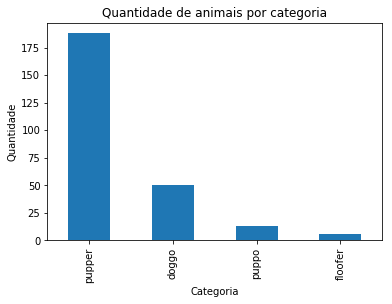

In [336]:
df_categorized.category.value_counts().plot(kind='bar');
plt.title('Quantidade de animais por categoria');
plt.xlabel('Categoria');
plt.ylabel('Quantidade');

Qual é a média de notas (`rating_numerator`) das categorias?

In [350]:
df_categorized.groupby('category').rating_numerator.agg(['min', 'max', 'mean'])

,min,max,mean
category,,,
doggo,5,14,11.520000
floofer,10,13,11.833333
pupper,3,14,10.484043
puppo,9,13,11.461538


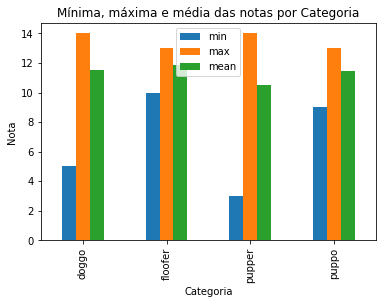

In [334]:
df_categorized.groupby('category').rating_numerator.agg(['min', 'max', 'mean']).plot(kind='bar');
plt.title('Mínima, máxima e média das notas por Categoria');
plt.xlabel('Categoria');
plt.ylabel('Nota');

Qual a média, máximo e minimo da contagem de tweets marcados como **favoritos** (`favorite_count`) entre as categorias?

In [328]:
df_categorized.groupby('category').favorite_count.agg(['min', 'max', 'mean'])

,min,max,mean
category,,,
doggo,2458,163034,19408.920000
floofer,2152,31685,10981.666667
pupper,661,121093,6033.872340
puppo,3093,139348,22861.538462


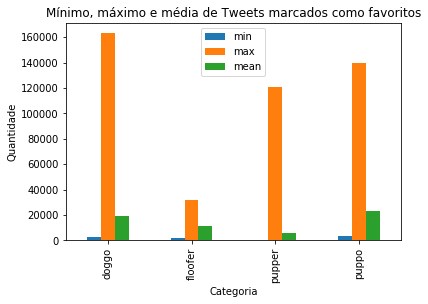

In [338]:
df_categorized.groupby('category').favorite_count.agg(['min', 'max', 'mean']).plot(kind='bar');
plt.title('Mínimo, máximo e média de Tweets marcados como favoritos');
plt.xlabel('Categoria');
plt.ylabel('Quantidade');

In [252]:
df_twitter_master.groupby('category').retweet_count.agg(['min', 'max', 'mean'])

,min,max,mean
category,,,
doggo,675,82905,7675.860000
floofer,465,17234,4813.833333
pupper,96,35138,2004.739362
puppo,658,47253,7113.769231


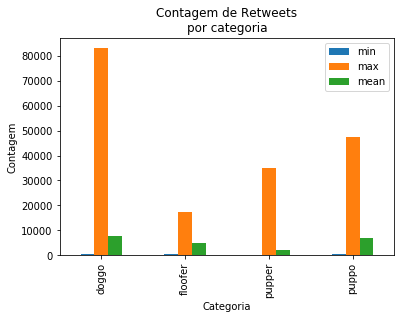

In [352]:
df_twitter_master.groupby('category').retweet_count.agg(['min', 'max', 'mean']).plot(kind='bar');
plt.title('Contagem de Retweets\npor categoria');
plt.xlabel('Categoria');
plt.ylabel('Contagem');

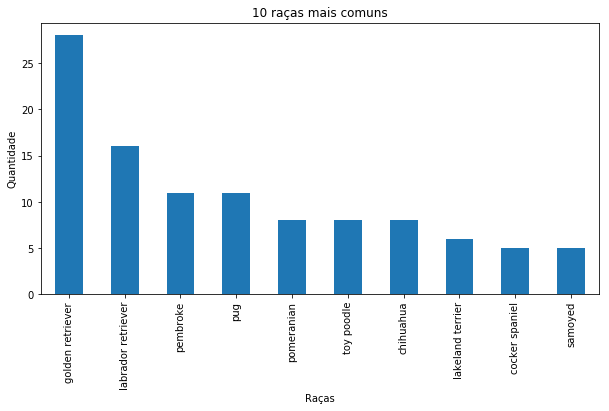

In [356]:
df_categorized.prediction_breed.value_counts().head(10).plot(kind='bar', figsize=(10, 5));
plt.title('10 raças mais comuns');
plt.xlabel('Raças');
plt.ylabel('Quantidade');

In [353]:
df_categorized.prediction_breed.value_counts().head(10)

golden retriever      28
labrador retriever    16
pembroke              11
pug                   11
pomeranian             8
toy poodle             8
chihuahua              8
lakeland terrier       6
cocker spaniel         5
samoyed                5
Name: prediction_breed, dtype: int64

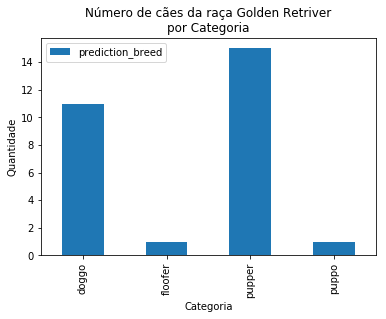

In [346]:
df_categorized.loc[df_twitter_master.prediction_breed == 'golden retriever', ['category', 'prediction_breed']].groupby('category').agg('count').plot(kind='bar');
plt.title('Número de cães da raça Golden Retriver\npor Categoria');
plt.xlabel('Categoria');
plt.ylabel('Quantidade');


In [366]:
df_categorized.loc[df_twitter_master.prediction_breed == 'golden retriever', ['category', 'prediction_breed']].groupby('category').agg('count')

,prediction_breed
category,
doggo,11
floofer,1
pupper,15
puppo,1


In [283]:
df_twitter_master.prediction_breed.value_counts().head(10)

golden retriever      141
labrador retriever     91
chihuahua              81
pembroke               80
pug                    58
toy poodle             49
chow                   43
pomeranian             37
samoyed                34
cocker spaniel         29
Name: prediction_breed, dtype: int64

Text(0, 0.5, 'retweet_count')

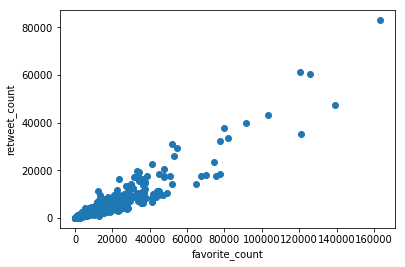

In [275]:
plt.scatter('favorite_count', 'retweet_count', data=df_twitter_master)
plt.xlabel('favorite_count')
plt.ylabel('retweet_count')

# Relatórios

* Data wrangling efforts
* Analyses and visualizations